# LSTM Model with Additional Features for TotalConsumption Prediction


## Ziel:
Das Notebook implementiert ein LSTM-Modell, das nicht nur **TotalConsumption**, sondern auch zusätzliche Features wie **Temperature**, **Humidity**, **Wind Speed**, **General Diffuse Flows** und **Diffuse Flows** berücksichtigt.

### Zusätzliche Features:
- **Temperature**: Umgebungstemperatur
- **Humidity**: Relative Luftfeuchtigkeit
- **Wind Speed**: Windgeschwindigkeit
- **General Diffuse Flows**: Diffuse Strahlung allgemein
- **Diffuse Flows**: Diffuse Strahlung spezifisch
    

In [16]:
%pip install pandas scikit-learn matplotlib seaborn plotly nbformat tensorflow==2.10.0 keras keras_tuner protobuf

Note: you may need to restart the kernel to use updated packages.


In [17]:

# Bibliotheken importieren
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


## 1. Datenvorbereitung

In [ ]:

# Daten laden
file_path = 'consumption-data/consumption.csv'
data = pd.read_csv(file_path)

# TotalConsumption berechnen
data['TotalConsumption'] = data['Zone 1 Power Consumption'] + data['Zone 2  Power Consumption'] + data['Zone 3  Power Consumption']

# Datumsformat und Index setzen
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)

# Zusätzliche Features einbeziehen
time_series = data[['TotalConsumption', 'Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows']]

# Skalierung vorbereiten
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Skalierung auf Zielwert und Features anwenden
scaled_target = target_scaler.fit_transform(time_series[['TotalConsumption']])
scaled_features = scaler.fit_transform(time_series.iloc[:, 1:])

# Kombinieren der skalierten Daten
combined_scaled = np.hstack([scaled_target, scaled_features])


In [19]:

# Funktion zur Sequenzgenerierung
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length, 1:])  # Features
        y.append(data[i + sequence_length, 0])    # Zielwert (TotalConsumption)
    return np.array(x), np.array(y)

# Sequenzen erstellen
sequence_length = 50
x, y = create_sequences(combined_scaled, sequence_length)

# Trainings- und Testdaten aufteilen
train_size = int(len(x) * 0.8)  # 80% der Daten für Training
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]


## 2. LSTM-Modell erstellen und trainieren

In [20]:

# Modell erstellen
model = Sequential()

# Erste GRU-Schicht
model.add(GRU(units=96, return_sequences=True, input_shape=(50, 5)))
model.add(Dropout(rate=0.3))

# Zweite GRU-Schicht
model.add(GRU(units=64, return_sequences=False))
model.add(Dropout(rate=0.3))

# Dense-Schichten
model.add(Dense(units=48, activation='relu'))
model.add(Dense(units=1))

# Kompilieren
model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=1e-6)

# Training
history = model.fit(x_train, y_train, epochs=100, batch_size=72, validation_data=(x_test, y_test),
                    verbose=1, callbacks=[early_stopping, lr_scheduler])


Epoch 1/100
582/582 [==============================] - 13s 11ms/step - loss: 0.0148 - val_loss: 0.0052 - lr: 0.0010
Epoch 2/100
582/582 [==============================] - 7s 12ms/step - loss: 0.0073 - val_loss: 0.0028 - lr: 0.0010
Epoch 3/100
582/582 [==============================] - 6s 11ms/step - loss: 0.0063 - val_loss: 0.0033 - lr: 0.0010
Epoch 4/100
582/582 [==============================] - 8s 13ms/step - loss: 0.0056 - val_loss: 0.0026 - lr: 0.0010
Epoch 5/100
582/582 [==============================] - 7s 11ms/step - loss: 0.0052 - val_loss: 0.0025 - lr: 0.0010
Epoch 6/100
582/582 [==============================] - 6s 11ms/step - loss: 0.0048 - val_loss: 0.0025 - lr: 0.0010
Epoch 7/100
582/582 [==============================] - 6s 11ms/step - loss: 0.0047 - val_loss: 0.0029 - lr: 0.0010
Epoch 8/100
582/582 [==============================] - 7s 12ms/step - loss: 0.0044 - val_loss: 0.0023 - lr: 0.0010
Epoch 9/100
582/582 [==============================] - 7s 11ms/step - loss: 0.0

## 3. Modellvorhersagen und Evaluierung

In [21]:

# Vorhersagen
full_predictions_scaled = model.predict(x)
full_predictions = target_scaler.inverse_transform(full_predictions_scaled)

# Tatsächliche Werte zurückskalieren
actual_values = target_scaler.inverse_transform(y.reshape(-1, 1))

# Testdaten-Vorhersagen zurückskalieren
test_predictions_scaled = model.predict(x_test)
test_predictions = target_scaler.inverse_transform(test_predictions_scaled)
test_actual_values = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Leistungsmetriken
mae = mean_absolute_error(test_actual_values, test_predictions)
rmse = mean_squared_error(test_actual_values, test_predictions, squared=False)
r2 = r2_score(test_actual_values, test_predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"R-Squared (R2): {r2}")


328/328 [==============================] - 1s 4ms/step
Mean Absolute Error (MAE): 3357.664477987016
Root Mean Square Error (RMSE): 4559.615971117611
R-Squared (R2): 0.895637722492552


c:\Users\TimSteiner\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 4. Visualisierungen

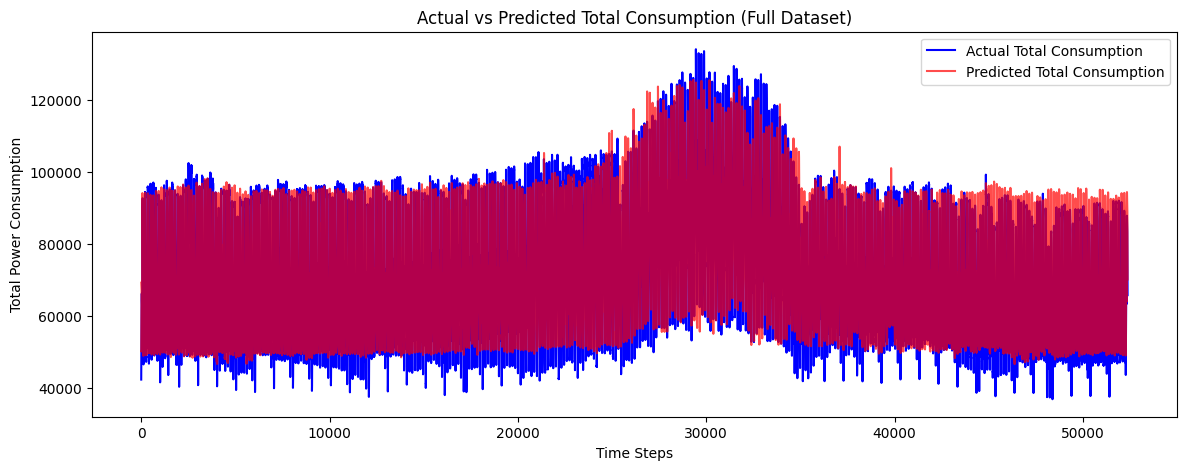

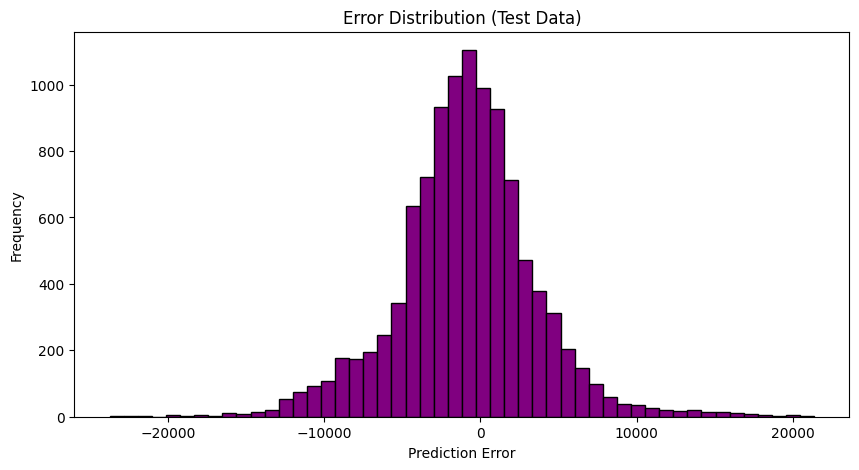

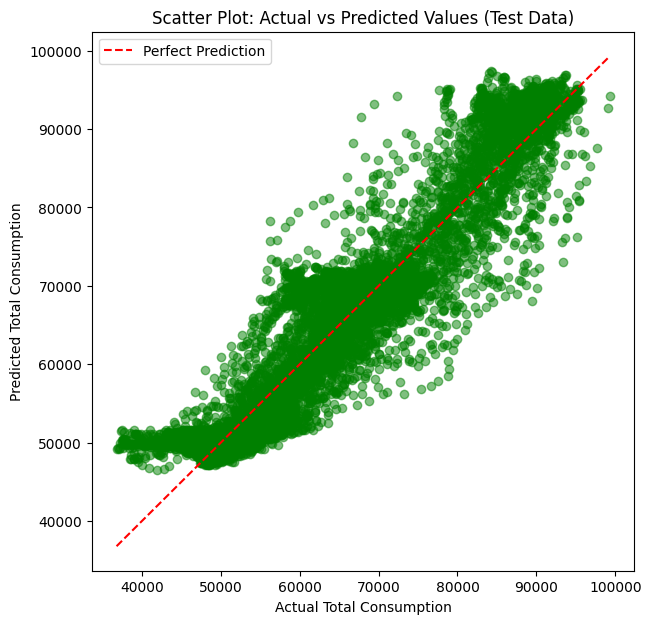

In [22]:

# Zeitserienvergleich
plt.figure(figsize=(14, 5))
plt.plot(actual_values, label='Actual Total Consumption', color='blue')
plt.plot(full_predictions, label='Predicted Total Consumption', color='red', alpha=0.7)
plt.title('Actual vs Predicted Total Consumption (Full Dataset)')
plt.xlabel('Time Steps')
plt.ylabel('Total Power Consumption')
plt.legend()
plt.show()

# Fehlerverteilung
errors = test_actual_values - test_predictions
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50, color='purple', edgecolor='black')
plt.title('Error Distribution (Test Data)')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

# Streudiagramm
plt.figure(figsize=(7, 7))
plt.scatter(test_actual_values, test_predictions, alpha=0.5, color='green')
plt.plot([min(test_actual_values), max(test_actual_values)],
         [min(test_actual_values), max(test_actual_values)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.title('Scatter Plot: Actual vs Predicted Values (Test Data)')
plt.xlabel('Actual Total Consumption')
plt.ylabel('Predicted Total Consumption')
plt.legend()
plt.show()
